# Sixth exercise (Chapter 8)

In this exercise we consider Chapter 8 of the book "Deep Learning". The exercise focuses on some optimization techniques  that represent the state-of-the-art for training neural networks.
In particular, you will implement SGD with different learning rate schedules, SGD with momentum and ADAM algorithms, and use them to train a small feedforward neural network on the MNIST dataset. Fianlly, you will be asked to answer few questions about second order methods.

List of covered topics: 

* Stochastic Gradient Descent with different learning rate decay heuristics (8.3.1)
* SGD with Momentum (8.3.2)
* Adam (8.5.3)
* Newton's Method (8.6.1)

Apart from the MNIST dataset and the mnist_loader.py file, both available on ILIAS, we also need a Python library called Numpy, for doing fast linear algebra. If you don't already have Numpy installed, please install it. 

### NOTE
In order to speed up the training, reduce the training set size to the first 10000 examples.

## Code

The following code implements a feedforward neural network together with the backpropagation and SGD algorithms. In the next points of this exercise you will be asked to add some extra optimization features to this implementation. 

In [1]:
#### Libraries
# Standard library
%matplotlib inline
import pickle
import gzip
import sys
import pdb

# Third-party libraries
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace

def load_data():

    f = gzip.open('data/mnist.pkl.gz', 'rb')
    training_data, validation_data, test_data = pickle.load(f, encoding='latin1')
    # training_data, validation_data, test_data = pickle.load(f)
    f.close()
    return (training_data, validation_data, test_data)

def load_datawrapper():

    tr_d, va_d, te_d = load_data()
    training_inputs = [np.reshape(x, (784, 1)) for x in tr_d[0]]     # flatten images to 1 dim vectors
    training_results = [vectorized_result(y) for y in tr_d[1]]       # one hot encode labels - only for training
    training_data = zip(training_inputs, training_results)           # make list of tuples inputs / label
    validation_inputs = [np.reshape(x, (784, 1)) for x in va_d[0]]
    validation_results = [vectorized_result(y) for y in va_d[1]]     # one hot encode labels - only for training
    validation_data = zip(validation_inputs, validation_results[1])  #  also flattened inputs, but lables not one hot encoded
    test_inputs = [np.reshape(x, (784, 1)) for x in te_d[0]]
    test_results = [vectorized_result(y) for y in te_d[1]]     # one hot encode labels - only for training   
    test_data = zip(test_inputs, test_results[1])
    return (list(training_data), list(validation_data), list(test_data))

def vectorized_result(j):

    e = np.zeros((10, 1))
    e[j] = 1.0
    return e

In [23]:
#### Libraries
# Standard library
import random

# Third-party libraries
import numpy as np

def sigmoid(z):
    return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
    return sigmoid(z)*(1-sigmoid(z))

def vectorized_result(j):   #  one-hot encode
    e = np.zeros((10, 1))
    e[j] = 1.0
    return e

# Define the Quadratic and the Cross-Entropy cost functions

class QuadraticCost(object):

    @staticmethod
    def fn(a, y):
        return 0.5*np.linalg.norm(a-y)**2
        
    @staticmethod
    def delta(z, a, y):
        return (a-y) * sigmoid_prime(z)

class CrossEntropyCost(object):

    @staticmethod
    def fn(a, y):    # bernoully or multinoulli distribution: y € {0,1}
        return np.sum(np.nan_to_num(-y*np.log(a)-(1-y)*np.log(1-a)))

    @staticmethod    # gradient after math short-cut
    def delta(z, a, y):
        return (a-y)



class Constant(object):   # Learning Rate Schedule
    
    @staticmethod
    def lr(lr_0, stepsize, nepochs, factor = 0.1, lr_min = 1e-9):   # return list len=nepochs with variing learning rates
        '''lr_0: initial value of the learning rate
           stepsize: length of step size (to be used only with CosineDecayRestart and Step classes)
           nepochs: total number of epochs
           
           the function should return a list of length=nepochs where element i is the value of the learning rate
           at epoch i 
        '''
        learning_rates = [lr_0 for number in range(nepochs)]
        return learning_rates
        
class Step(object):
    
    def lr(lr_0, stepsize, nepochs, factor = 2.0, lr_min = 1e-9):
        # reduce the learning rate by a factor each stepsize steps
        learning_rates = []
        lr = lr_0
        for epoch in range(nepochs):
            learning_rates.append(lr)            
            if epoch % stepsize == 0:
                lr = lr * factor
        return learning_rates

class Linear(object):
    
    @staticmethod
    def lr(lr_0, stepsize, nepochs, factor = 1.1, lr_min = 1e-9):
        learning_rates = []
        # set_trace()
        lr = lr_0
        for epoch in range(nepochs):
            learning_rates.append(lr)
            lr = lr * factor            
        return learning_rates        
        # learning_rates = [lr / factor for i range(nepochs)]
    
class CosineDecay(object):
    
    @staticmethod
    def lr(lr_0, stepsize, nepochs, factor = 0.1, lr_min = 1e-9):
        
        learning_rates = []
        lr = lr_0        
        for epoch in range(nepochs):    # from Ilya Loshchilov & Frank Hutter paper
            lr = lr_min + 0.5 * (lr_0 - lr_min) * (1 + np.cos((epoch / (nepochs-1) * np.pi)))
            learning_rates.append(lr)
        return learning_rates  

    
class CosineDecayRestart(object):
    
    # perform several runs with restarts. After one run with stepsize steps, lr returns to  
    # lr 
    @staticmethod
    def lr(lr_0, stepsize, nepochs, factor = 2.0, lr_min = 1e-9):

        learning_rates = []
        lr = lr_0
        stepsize_f = stepsize     
        epoch_in_run = 0
        last_at_mu_min = 0
        # set_trace()
        for epoch in range(nepochs):
            if (epoch_in_run == stepsize): 
                epoch_in_run = 0       # start new run when reach stepsize
                stepsize_f *= factor   # allow for non discrete factors for flexibility
                stepsize = int(stepsize_f)  # set actual stepsize to integer number
                # stepsize = int(stepsize*factor)     # each run gets longer then previous by factor t_mult
                # last_restart = epoch   # memorise the index (epoch) of last restart
                

            # at new run lr returns to = lr_0. Then decay during run. 
            # At end of run (nepochs_in_run = stepsize) lr = lr_min
            lr = lr_min + 0.5 * (lr_0 - lr_min) * (1 + np.cos(epoch_in_run / max(stepsize-1,1) * np.pi))

            epoch_in_run += 1      # continue run
            
            learning_rates.append(lr)
            
            if epoch_in_run == stepsize - 1:
                last_at_mu_min = epoch + 1   # memorise index of last epoch before restart (at mu_min)
            
        # according to Loshchilov & Hutter and intuitively at the epochs after the restarts 
        # results might worsen (starting with large l_rates)
        # the recommended solution is, to take the last epoch (= smallest learning_rate) of the last "sub-runs",
        if last_at_mu_min > 0:
            del learning_rates[last_at_mu_min+1:]
            
        return learning_rates        

class Network(object):

    def __init__(self, sizes, cost=QuadraticCost, lr_schedule=Constant):

        self.num_layers = len(sizes)
        self.sizes = sizes   
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]  
        self.weights = [np.random.randn(y, x)
                        for x, y in zip(sizes[:-1], sizes[1:])]
        self.cost = cost
        self.lr_schedule = lr_schedule

    def feedforward(self, a):

        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a)+b)
        return a
    
    def SGD(self, training_data, epochs, mini_batch_size, 
            stepsize=1, lr_0=0.1, factor=0.8, lr_min = 1e-9,
            momentum=False,
            alpha=0,
            evaluation_data=None,
            monitor_evaluation_cost=False,
            monitor_evaluation_accuracy=False,
            monitor_training_cost=False,
            monitor_training_accuracy=False,
            filename_config=None,
            filename_results=None):

        n_data = 0
        if evaluation_data: 
            n_data = len(evaluation_data)
        n = len(training_data)
        evaluation_cost, evaluation_accuracy = [], []
        training_cost, training_accuracy = [], []
        
        lr_list = self.lr_schedule.lr(lr_0, stepsize, epochs, factor = factor, lr_min = lr_min)

        print("generated lr_list \n{}".format(lr_list))
        
        # initialize moment estimates
        if momentum:
            v_b = [np.zeros(b.shape) for b in self.biases]
            v_w = [np.zeros(w.shape) for w in self.weights]        
            self.first_moment_estimates = (v_b, v_w)        
     
        for j in range(len(lr_list)):  # in case of CosineDecayRestart shorter than epochs
            random.shuffle(training_data)
            mini_batches = [
                training_data[k:k+mini_batch_size]
                for k in range(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, lr_list[j], momentum , alpha)
                
            print ("Epoch {0} complete".format(j))
            
            if monitor_training_cost:
                cost = self.total_cost(training_data)
                training_cost.append(cost)
                print ("Cost on training data: {}".format(cost))
            if monitor_training_accuracy:
                accuracy = self.accuracy(training_data)
                training_accuracy.append(accuracy)
                print ("Accuracy on training data: {} / {}".format(
                    accuracy, n))
            if monitor_evaluation_cost:
                cost = self.total_cost(evaluation_data)
                evaluation_cost.append(cost)
                print ("Cost on evaluation data: {}".format(cost))
            if monitor_evaluation_accuracy:
                accuracy = self.accuracy(evaluation_data)
                evaluation_accuracy.append(accuracy)
                print ("Accuracy on evaluation data: {} / {}".format(
                    self.accuracy(evaluation_data), n_data))   
        return training_cost, training_accuracy, evaluation_cost, evaluation_accuracy, lr_list

    def update_mini_batch(self, mini_batch, eta, momentum, alpha):
    
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
            
        if momentum:
            # unpack current moment estimates (here v_b, v_w together representing "v" in 8.15)
            (v_b, v_w) = self.first_moment_estimates
            
            # update moment estimates (v = alpha*v - eta * 1/m * nabla_theta)
            v_b = [alpha*vb - (eta/len(mini_batch)) * nb for (vb, nb) in zip(v_b, nabla_b)]            
            v_w = [alpha*vw - (eta/len(mini_batch)) * nw for (vw, nw) in zip(v_w, nabla_w)]            
            
            # update Theta
            self.biases =  [b + nb for b, nb in zip(self.biases, v_b)] 
            self.weights = [w + nw for w, nw in zip(self.weights, v_w)]
        
        else:
            self.weights = [w-(eta/len(mini_batch))*nw for w, nw in zip(self.weights, nabla_w)]
            self.biases = [b-(eta/len(mini_batch))*nb for b, nb in zip(self.biases, nabla_b)] 
    

    def Adam(self, training_data, epochs, mini_batch_size, stepsize=1, lr_0=0.1,
            rho_1=0.9,
            rho_2=0.999,
            delta=10**(-8),
            evaluation_data=None,
            monitor_evaluation_cost=False,
            monitor_evaluation_accuracy=False,
            monitor_training_cost=False,
            monitor_training_accuracy=False,
            filename_config=None,
            filename_results=None):
      
        if evaluation_data: n_data = len(evaluation_data)
        n = len(training_data)
        evaluation_cost, evaluation_accuracy = [], []
        training_cost, training_accuracy = [], []
        lr_list = (self.lr_schedule).lr(lr_0, stepsize, epochs)
        # lr_list = self.lr_schedule.lr(lr_0, stepsize, epochs, factor = factor, lr_min = lr_min) 
        
        # initialize moment estimates
        s_b = [np.zeros(b.shape) for b in self.biases]
        s_w = [np.zeros(w.shape) for w in self.weights]
        r_b = [np.zeros(b.shape) for b in self.biases]
        r_w = [np.zeros(w.shape) for w in self.weights]  
        self.first_moment_estimates = (s_b, s_w)
        self.second_moment_estimates = (r_b, r_w)        
        
        t = 0
        for j in range(epochs):
            random.shuffle(training_data)
            mini_batches = [
                training_data[k:k+mini_batch_size]
                for k in range(0, n, mini_batch_size)]
            
            for mini_batch in mini_batches:
                t = t+1
                self.update_mini_batch_adam(mini_batch, lr_list[j], rho_1, rho_2, delta, t)
                
            print ("Epoch {0} complete".format(j))
            
            if monitor_training_cost:
                cost = self.total_cost(training_data)
                training_cost.append(cost)
                print ("Cost on training data: {}".format(cost))
            if monitor_training_accuracy:
                accuracy = self.accuracy(training_data)
                training_accuracy.append(accuracy)
                print ("Accuracy on training data: {} / {}".format(
                    accuracy, n))
            if monitor_evaluation_cost:
                cost = self.total_cost(evaluation_data)
                evaluation_cost.append(cost)
                print ("Cost on evaluation data: {}".format(cost))
            if monitor_evaluation_accuracy:
                accuracy = self.accuracy(evaluation_data)
                evaluation_accuracy.append(accuracy)
                print ("Accuracy on evaluation data: {} / {}".format(
                    self.accuracy(evaluation_data), n_data))
        return training_cost, training_accuracy, evaluation_cost, evaluation_accuracy, lr_list

    def update_mini_batch_adam(self, mini_batch, eta, rho_1, rho_2, delta, t):
        '''
        mini_batch: the mini batch considered in the current subepoch 
        eta: value of the learning rate for the current epoch
        rho_1: Adam's parameter (see par. 8.5.3)
        rho_2: Adam's parameter (see par. 8.5.3)
        delta: Adam's correction term (see par. 8.5.3)
        t: number of gradient's updates that has been done so far
        
        the function should update the parameters of the network (self.weights and self.biases) 
        based on Adam's update rule.
        '''
        # compute gradient as usually
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
            
        # unpack moment estimates
        (s_b, s_w) = self.first_moment_estimates
        (r_b, r_w) = self.second_moment_estimates
            
        # first moment estimate
        s_b = [rho_1 * s + (1 - rho_1) * d for (s, d) in zip(s_b, nabla_b)]
        s_w = [rho_1 * s + (1 - rho_1) * d for (s, d) in zip(s_w, nabla_w)]
        
        # second moment estimate
        r_b = [rho_2 * r + (1 - rho_2) * d * d for (r, d) in zip(r_b, nabla_b)]
        r_w = [rho_2 * r + (1 - rho_2) * d * d for (r, d) in zip(r_w, nabla_w)]
        # (in numpy, ndarray multiplication is by default element-wise)
        
        # correct bias in first moment
        s_hat_b = [s / (1 - rho_1 ** t) for s in s_b]
        s_hat_w = [s / (1 - rho_1 ** t) for s in s_w]
        
        # correct bias in second moment
        r_hat_b = [r / (1 - rho_2 ** t) for r in r_b]
        r_hat_w = [r / (1 - rho_2 ** t) for r in r_w]
        
        # compute and apply update
        self.biases = [b - (eta/len(mini_batch)) * s_hat / (np.sqrt(r_hat) + delta)
                       for (b, s_hat, r_hat) in zip(self.biases, s_hat_b, r_hat_b)]
        self.weights = [w - (eta/len(mini_batch)) * s_hat / (np.sqrt(r_hat) + delta)
                        for (w, s_hat, r_hat) in zip(self.weights, s_hat_w, r_hat_w)]

        # save moment estimates
        self.first_moment_estimates = (s_b, s_w)
        self.second_moment_estimates = (r_b, r_w)

            
    def backprop(self, x, y):
  
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        # feedforward
        activation = x
        activations = [x] # list to store all the activations, layer by layer
        zs = [] # list to store all the z vectors, layer by layer
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation)+b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
        # backward pass
        delta = (self.cost).delta(zs[-1], activations[-1], y)
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        # Note that the variable l in the loop below is used in the following way:
        # l = 1 means the last layer of neurons, l = 2 is the
        # second-last layer, and so on.  It's a renumbering of the
        # scheme in the book, used here to take advantage of the fact
        # that Python can use negative indices in lists.
        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return (nabla_b, nabla_w)
    
    def accuracy(self, data):

        results = [(np.argmax(self.feedforward(x)), np.argmax(y)) for (x, y) in data]

        return sum(int(x == y) for (x, y) in results)

    def total_cost(self, data):
    
        cost = 0.0
        for x, y in data:
            a = self.feedforward(x)
            cost += self.cost.fn(a, y)/len(data)
        return cost 



## Stochastic Gradient Descent (SGD) with different learning rate decay heuristics

Stochastic gradient descent based algorithms represent the-state-of-the-art to train deep neural networks. As you might have experienced, and as it is stated in the book, one of the major drawbacks of these methods is their great sensitivity to the learning rate value: performances indeed change dramatically with different values of this parameter. In exercise 04 we trained an MLP with SGD using a fixed learning rate value:in general practitioners decrease it to have better performances.Implement the following different heuristics for the learning rate value: constant, step decay, linear decay, cosine decay, and cosine decay with restarts. In order to achieve this goal, follow the '#TODO:learning_rate' indications in the code. Then use each one of these heuristics to train a feedforward neural network with 2 hidden layers of 30 and 100 neurons respectively. In particular: set the initial value for the learning rate to 3.0, the stepsize to 7, and train the network for 30 epochs with a batch size of 10 on the MNIST dataset. Finally, generate two plots for each experiment: learning rate vs epochs, and test accuracy vs epochs.

In [18]:
# import mnist_loader

# training_data, validation_data, test_data = mnist_loader.load_datawrapper()
# training_data, validation_data, test_data = load_datawrapper()
original_train_data, gaga, gogo = load_datawrapper()
training_data = original_train_data[:10000]
validation_data = original_train_data[10000:11000]
test_data = original_train_data[11000:12000]
# training_data = training_data[:10000]

num_training_examples = len(training_data) 
num_validation_examples = len(validation_data)
num_test_examples = len(test_data)

num_features = len(training_data[0][0])
num_classes = len(training_data[0][1])


In [8]:
def lr_schedule(lr_schedule, factor=1.0):
    # set_trace()
    net = Network([num_features,30,100,num_classes], cost=QuadraticCost, lr_schedule=lr_schedule)   
    t_cost, t_accuracy, e_cost, e_accuracy, lr_list = net.SGD(training_data, 30, 10,    # epochs / batch size
                stepsize=7, lr_0=3, factor=factor, lr_min = 0.01,
                momentum = False,
                evaluation_data=test_data,
                monitor_evaluation_cost=True,
                monitor_evaluation_accuracy=True,
                monitor_training_cost=True,
                monitor_training_accuracy=True)
    return lr_list, t_accuracy

In [24]:
def lr_schedule(lr_schedule, factor=1.0):
    # set_trace()
    net = Network([num_features,30,100,num_classes], cost=QuadraticCost, lr_schedule=lr_schedule)   
    t_cost, t_accuracy, e_cost, e_accuracy, lr_list = net.SGD(training_data, 30, 10,    # epochs / batch size
                stepsize=7, lr_0=3, factor=factor, lr_min = 0.01,
                momentum = False,
                evaluation_data=test_data,
                monitor_evaluation_cost=True,
                monitor_evaluation_accuracy=True,
                monitor_training_cost=True,
                monitor_training_accuracy=True)
    return lr_list, t_accuracy

In [25]:
lr_lists = []
t_accuracies = []
lr_list, t_accuracie = lr_schedule(Constant)
lr_lists.append(lr_list)
t_accuracies.append(t_accuracie)
lr_list, t_accuracie = lr_schedule(Step, factor=0.5)
lr_lists.append(lr_list)
t_accuracies.append(t_accuracie)
lr_list, t_accuracie = lr_schedule(Linear, factor=0.9)
lr_lists.append(lr_list)
t_accuracies.append(t_accuracie)
lr_list, t_accuracie = lr_schedule(CosineDecay)
lr_lists.append(lr_list)
t_accuracies.append(t_accuracie)
lr_list, t_accuracie = lr_schedule(CosineDecayRestart, factor=2)
lr_lists.append(lr_list)
t_accuracies.append(t_accuracie)

generated lr_list 
[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
Epoch 0 complete
Cost on training data: 0.28710383525081073
Accuracy on training data: 6038 / 10000
Cost on evaluation data: 0.283657006819818
Accuracy on evaluation data: 618 / 1000
Epoch 1 complete
Cost on training data: 0.10361157489974153
Accuracy on training data: 8780 / 10000
Cost on evaluation data: 0.12379055115751522
Accuracy on evaluation data: 856 / 1000
Epoch 2 complete
Cost on training data: 0.10353547223274849
Accuracy on training data: 8762 / 10000
Cost on evaluation data: 0.1275020387038546
Accuracy on evaluation data: 865 / 1000
Epoch 3 complete
Cost on training data: 0.06899382294628183
Accuracy on training data: 9177 / 10000
Cost on evaluation data: 0.09992225483454782
Accuracy on evaluation data: 877 / 1000
Epoch 4 complete
Cost on training data: 0.058628866077989845
Accuracy on training data: 9296 / 10000
Cost on evaluation data: 0.08360142265393711
Accurac

Epoch 13 complete
Cost on training data: 0.035695152746644504
Accuracy on training data: 9552 / 10000
Cost on evaluation data: 0.07486538268218061
Accuracy on evaluation data: 907 / 1000
Epoch 14 complete
Cost on training data: 0.03430466335482441
Accuracy on training data: 9565 / 10000
Cost on evaluation data: 0.07398600825522102
Accuracy on evaluation data: 912 / 1000
Epoch 15 complete
Cost on training data: 0.03332039113378254
Accuracy on training data: 9586 / 10000
Cost on evaluation data: 0.07433567558096658
Accuracy on evaluation data: 908 / 1000
Epoch 16 complete
Cost on training data: 0.03235991047623256
Accuracy on training data: 9583 / 10000
Cost on evaluation data: 0.07324792668939313
Accuracy on evaluation data: 907 / 1000
Epoch 17 complete
Cost on training data: 0.031846027984023084
Accuracy on training data: 9595 / 10000
Cost on evaluation data: 0.07282960780487023
Accuracy on evaluation data: 909 / 1000
Epoch 18 complete
Cost on training data: 0.031066163627302947
Accura

Epoch 24 complete
Cost on training data: 0.023374554852577882
Accuracy on training data: 9689 / 10000
Cost on evaluation data: 0.06715887241975535
Accuracy on evaluation data: 914 / 1000
Epoch 25 complete
Cost on training data: 0.023127319591100877
Accuracy on training data: 9692 / 10000
Cost on evaluation data: 0.0674005599242714
Accuracy on evaluation data: 911 / 1000
Epoch 26 complete
Cost on training data: 0.02297381243315859
Accuracy on training data: 9687 / 10000
Cost on evaluation data: 0.06790254598617679
Accuracy on evaluation data: 913 / 1000
Epoch 27 complete
Cost on training data: 0.02279135131638516
Accuracy on training data: 9692 / 10000
Cost on evaluation data: 0.06775470355088907
Accuracy on evaluation data: 913 / 1000
Epoch 28 complete
Cost on training data: 0.022713447381647676
Accuracy on training data: 9696 / 10000
Cost on evaluation data: 0.06808477129879213
Accuracy on evaluation data: 912 / 1000
Epoch 29 complete
Cost on training data: 0.022622969477709802
Accura

Epoch 3 complete
Cost on training data: 0.09773364281197254
Accuracy on training data: 8505 / 10000
Cost on evaluation data: 0.12802310108850026
Accuracy on evaluation data: 812 / 1000
Epoch 4 complete
Cost on training data: 0.09439263153028699
Accuracy on training data: 8549 / 10000
Cost on evaluation data: 0.12183114795938806
Accuracy on evaluation data: 829 / 1000
Epoch 5 complete
Cost on training data: 0.09049068971775816
Accuracy on training data: 8582 / 10000
Cost on evaluation data: 0.11997246883933708
Accuracy on evaluation data: 825 / 1000
Epoch 6 complete
Cost on training data: 0.0900575848381979
Accuracy on training data: 8577 / 10000
Cost on evaluation data: 0.1196044850314801
Accuracy on evaluation data: 824 / 1000
Epoch 7 complete
Cost on training data: 0.09886821644996516
Accuracy on training data: 8509 / 10000
Cost on evaluation data: 0.13007762234606057
Accuracy on evaluation data: 812 / 1000
Epoch 8 complete
Cost on training data: 0.09501449353062809
Accuracy on train

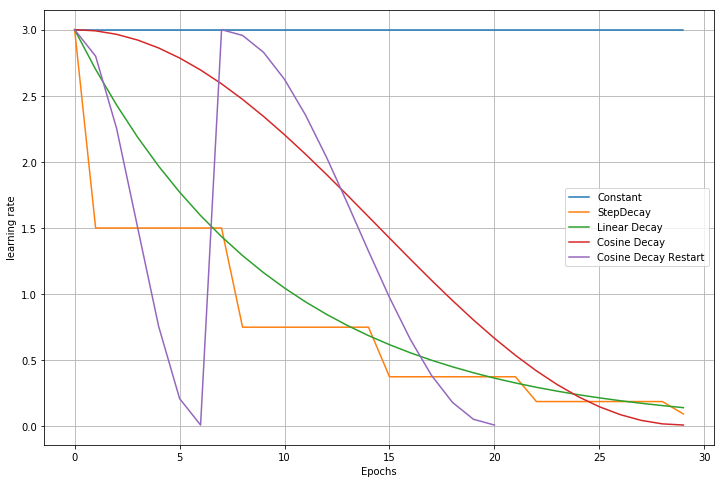

In [26]:
plt.figure(figsize=(12, 8))
plt.plot(lr_lists[0], label="Constant")
plt.plot(lr_lists[1], label="StepDecay")
plt.plot(lr_lists[2], label="Linear Decay")
plt.plot(lr_lists[3], label="Cosine Decay")
plt.plot(lr_lists[4], label="Cosine Decay Restart")
plt.grid(True)
plt.xlabel("Epochs")
plt.ylabel("learning rate")
plt.legend(loc='best')

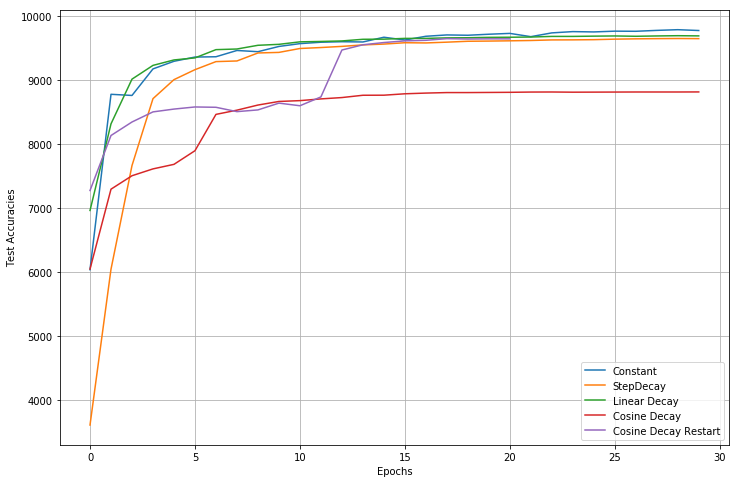

In [27]:
plt.figure(figsize=(12, 8))
plt.plot(t_accuracies[0], label="Constant")
plt.plot(t_accuracies[1], label="StepDecay")
plt.plot(t_accuracies[2], label="Linear Decay")
plt.plot(t_accuracies[3], label="Cosine Decay")
plt.plot(t_accuracies[4], label="Cosine Decay Restart")
plt.grid(True)
plt.xlabel("Epochs")
plt.ylabel("Test Accuracies")
plt.legend(loc='best')

There is no advantage of the more advanced methods visible for these data. 
This might be, because the complexity of the task and the capacity of the network (only two layers) are too shallow to benefit from the more elaborated methods.

## Momentum

In presence of an ill conditioned Hessian matrix, it might be useful to consider an exponentially decaying moving average of the past gradients in order to speed up the learning. SGD with momentum (see equations 8.15 and 8.16 in the book) has indeed been designed to take into consideration not only the current direction given by the negative gradient, but also how large and aligned is a sequence of past gradients with respect to the current one. Modify your previous implementation of SGD to incorporate the momentum by following the '#TODO:momentum' instructions in the code, then use it to train the network on the MNIST dataset with an initial learning rate of 3.0, cosine with restarts decay and $\alpha= 0.3$. Finally plot the results obtained: test accuracy vs number of epochs.

In [21]:
net = Network([num_features,30,100,num_classes], cost=QuadraticCost, lr_schedule=CosineDecayRestart)   
t_cost, t_accuracy, e_cost, e_accuracy, lr_list = net.SGD(training_data, 30, 10,    # epochs / batch size
            lr_0=3.0, factor=2,
            momentum = True,
            alpha = 0.3,
            evaluation_data=test_data,
            monitor_evaluation_cost=True,
            monitor_evaluation_accuracy=True,
            monitor_training_cost=True,
            monitor_training_accuracy=True)

generated lr_list 
[3.0, 3.0, 1.0000000000000001e-09, 3.0, 2.25000000025, 0.75000000075000028, 1.0000000000000001e-09, 3.0, 2.8514533019031441, 2.4352347029763557, 1.833781401323211, 1.1662185996767891, 0.56476529802364461, 0.14854669909685589, 1.0000000000000001e-09, 3.0, 2.9672214011116349, 2.8703181865071286, 2.7135254916579128, 2.5036959097037221, 2.25000000025, 1.9635254919079128, 1.656792695349216, 1.3432073056507843, 1.0364745090920875, 0.75000000075000028, 0.49630409129627845, 0.28647450934208751, 0.12968181449287125, 0.032778599888365269]
Epoch 0 complete
Cost on training data: 0.216708387822146
Accuracy on training data: 6756 / 10000
Cost on evaluation data: 0.2317445981819771
Accuracy on evaluation data: 655 / 1000
Epoch 1 complete
Cost on training data: 0.1441921118015212
Accuracy on training data: 7909 / 10000
Cost on evaluation data: 0.18062482295968954
Accuracy on evaluation data: 739 / 1000
Epoch 2 complete
Cost on training data: 0.14419211065162435
Accuracy on training

SyntaxError: 'return' outside function (<ipython-input-21-1df3e2ab9966>, line 11)

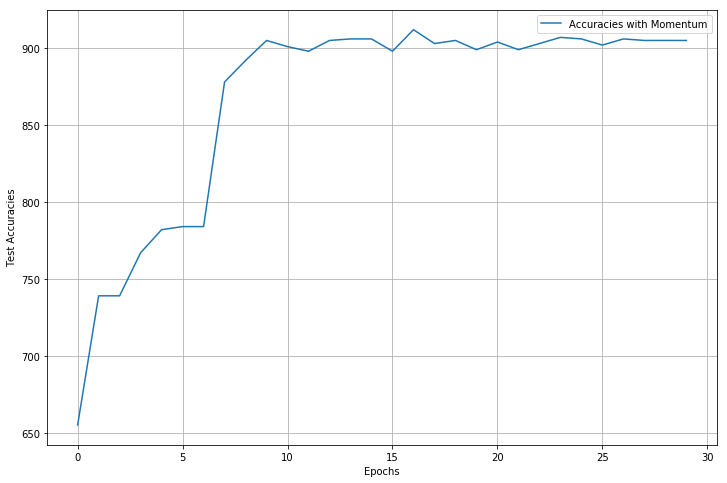

In [22]:
plt.figure(figsize=(12, 8))
plt.plot(e_accuracy, label="Accuracies with Momentum")
plt.grid(True)
plt.xlabel("Epochs")
plt.ylabel("Test Accuracies")
plt.legend(loc='best')

Mention another method that could be used to address the ill conditioning of the Hessian matrix.

Conjugate Gradient is another method, that can help especially in cases, where the size of the different eigenvalues of the Hessian varies strongly: "steep" and long valleys, where the trajectories might be caused to oszillate in the directions of the high eigenvalues rather than walking down the valley, as in fig. 8.5.

Adam should also be able to handle situations with an ill conditioned Hessian, as it incorporates the concept of momentum, and combines it with the consideration of the historic gradients (as in RMS Prop).

## Adam

Adam is one of the most popular algorithms used for training neural networks. Implement it in the code where required by the '#TODO:Adam' instructions, and use it train our network on the MNSIT dataset. In particular, set $\rho_1 = 0.9$, $\rho_2 = 0.999$ and $\delta=10^{-8}$. Plot the results obtained (test accuracy vs number of epochs) for a fixed learning rate of 0.1.  

In [5]:
#TODO:Adam
net = Network(sizes=[num_features, 30, 100, num_classes], cost=QuadraticCost, lr_schedule=Constant)
results = net.Adam(training_data=training_data, epochs=50, mini_batch_size=10, lr_0=0.1,
                   evaluation_data=test_data,
                   monitor_evaluation_cost=True,
                   monitor_evaluation_accuracy=True,
                   monitor_training_cost=True,
                   monitor_training_accuracy=True)

Epoch 0 complete
Cost on training data: 0.3005294151490826
Accuracy on training data: 4770 / 10000
Cost on evaluation data: 0.3011283913355212
Accuracy on evaluation data: 475 / 1000
Epoch 1 complete
Cost on training data: 0.19994180593727875
Accuracy on training data: 6584 / 10000
Cost on evaluation data: 0.203782077215955
Accuracy on evaluation data: 666 / 1000
Epoch 2 complete
Cost on training data: 0.2005048574911325
Accuracy on training data: 6581 / 10000
Cost on evaluation data: 0.19658859298412534
Accuracy on evaluation data: 672 / 1000
Epoch 3 complete
Cost on training data: 0.18774837053517612
Accuracy on training data: 6728 / 10000
Cost on evaluation data: 0.18980755726863124
Accuracy on evaluation data: 682 / 1000
Epoch 4 complete
Cost on training data: 0.1815938177988033
Accuracy on training data: 6763 / 10000
Cost on evaluation data: 0.18242610729230876
Accuracy on evaluation data: 689 / 1000
Epoch 5 complete
Cost on training data: 0.18200618659380885
Accuracy on training 

Accuracy on training data: 9751 / 10000
Cost on evaluation data: 0.06127537628914798
Accuracy on evaluation data: 932 / 1000
Epoch 45 complete
Cost on training data: 0.025124124873809568
Accuracy on training data: 9715 / 10000
Cost on evaluation data: 0.07091937781669519
Accuracy on evaluation data: 921 / 1000
Epoch 46 complete
Cost on training data: 0.01849416000586718
Accuracy on training data: 9792 / 10000
Cost on evaluation data: 0.06449735246090137
Accuracy on evaluation data: 929 / 1000
Epoch 47 complete
Cost on training data: 0.021287665974522772
Accuracy on training data: 9761 / 10000
Cost on evaluation data: 0.06882381909198228
Accuracy on evaluation data: 926 / 1000
Epoch 48 complete
Cost on training data: 0.020359542726873528
Accuracy on training data: 9755 / 10000
Cost on evaluation data: 0.061258359625855185
Accuracy on evaluation data: 937 / 1000
Epoch 49 complete
Cost on training data: 0.0204380016563147
Accuracy on training data: 9774 / 10000
Cost on evaluation data: 0.

'\ndef lr_schedule(lr_schedule, factor=1.0):\n    # set_trace()\n    net = Network([num_features,30,100,num_classes], cost=QuadraticCost, lr_schedule=lr_schedule)   \n    t_cost, t_accuracy, e_cost, e_accuracy, lr_list = net.SGD(training_data, 30, 10,    # epochs / batch size\n                stepsize=7, lr_0=3, factor=factor, lr_min = 0.01,\n                momentum = False,\n                evaluation_data=test_data,\n                monitor_evaluation_cost=True,\n                monitor_evaluation_accuracy=True,\n                monitor_training_cost=True,\n                monitor_training_accuracy=True)\n    return lr_list, t_accuracy\n'

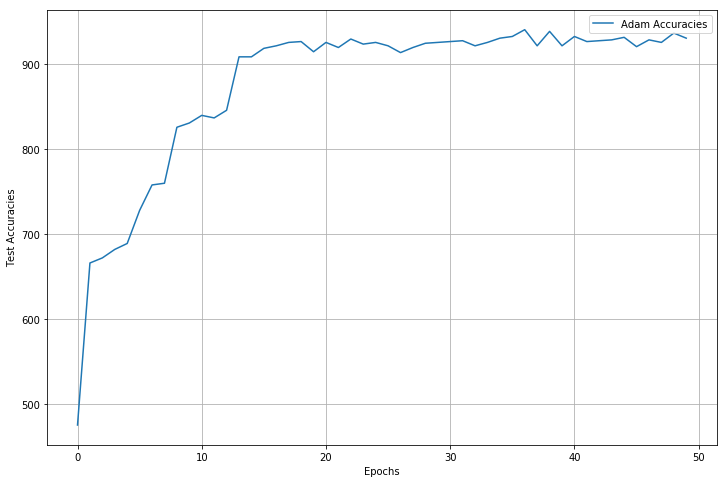

In [6]:
plt.figure(figsize=(12, 8))
plt.plot(results[3], label="Adam Accuracies")
plt.grid(True)
plt.xlabel("Epochs")
plt.ylabel("Test Accuracies")
plt.legend(loc='best')

Briefly explain the Newton's method and why it is not possible to use it for training networks with a significant number of parameters. 

Newtons Method builds on the assumption, that the actual function J(theta) can be approximated reasonable as a quadratic function of the weights Theta (second order Taylor series). During Training it does not only estimate the gradient, but also the second order derivative of J(Theta), thus the Hessian matrix. Based on the Hessian, the algorithm tries to jump to the minimum directly (which would work perfectly, if the function where actually quadratic, and works iteratively with good results, if the second order approximation is good).

In order to find Minima, Newtons Method searches for points with zero gradient ("critical points"). But these are only minima, if their second order derivatives are all positive.  Statistically, for high dimensional situations, it is far more likely, that a critical point is a saddle point, where the second derivative is positive in some directions, and negative in others, and the function is thus non_convex.

Moreover the estimation as well as the inversion of the hessian is computationally expensive in high dimensional cases, as the number of entries in the hessian matrix equals the square of the number of parameters.